In [1]:
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import defaultdict
import datetime

#set pwd
dirpath = os.getcwd()
print("current directory is : " + dirpath)
foldername = os.path.basename(dirpath)
print("Directory name is : " + foldername)

current directory is : C:\Users\D4rkmatter\Projects\petdata
Directory name is : petdata


<h2>Import and Simple Exploration</h2>

In [2]:
#Import

pet_data = pd.read_csv(dirpath+'/petdata.csv')
claim_data = pd.read_csv(dirpath+'/claimdata.csv')

In [3]:
#Take a look

print('Pet Data')
pet_data.head()
pet_data.info()
print('\n')
print('Claim Data')
claim_data.head()
claim_data.info()


Pet Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
PetId          10000 non-null int64
EnrollDate     10000 non-null object
CancelDate     4879 non-null object
Species        10000 non-null object
Breed          10000 non-null object
AgeAtEnroll    10000 non-null object
dtypes: int64(1), object(5)
memory usage: 468.9+ KB


Claim Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37049 entries, 0 to 37048
Data columns (total 4 columns):
ClaimId        37049 non-null int64
PetId          37049 non-null int64
ClaimDate      37049 non-null object
ClaimAmount    37049 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.1+ MB


In [4]:
#Join the dataframes

master_df = pet_data.join(claim_data.set_index('PetId'))
master_df.head()
#df.info()

,PetId,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,ClaimId,ClaimDate,ClaimAmount
0,0,2015-08-11,2018-07-13,Dog,Mixed Breed,5 years old,NaN,NaN,NaN
1,1,2014-02-15,2016-01-25,Cat,Mixed Breed,3 years old,NaN,NaN,NaN
2,2,2014-12-20,NaN,Dog,French Bulldog,8 weeks to 12 months old,7633.0,2018-02-14,82.80
2,2,2014-12-20,NaN,Dog,French Bulldog,8 weeks to 12 months old,13987.0,2018-08-07,190.69
2,2,2014-12-20,NaN,Dog,French Bulldog,8 weeks to 12 months old,24729.0,2018-04-14,346.61


<h2>Unfiltered Dataset Preliminary Correlation with ClaimAmount</h2>

In [5]:
def corr_helper(df):
    #correlation mapping helper function
    correlations = {}
    columns = ['Species','Breed','AgeAtEnroll']
    for column in columns:
        correlations[column] = df[column].str.get_dummies().corrwith(df.ClaimAmount)
        print(column,'Correlations \n',correlations[column],'\n')
        
corr_helper(master_df)

#NOTE
#To improve, bin the enroll dates and look for correlation.


Species Correlations 
 Cat   -0.012385
Dog    0.012385
dtype: float64 

Breed Correlations 
 Chihuahua           0.012405
French Bulldog      0.025846
Golden Retriever   -0.010085
Great Dane         -0.010346
Mixed Breed        -0.007777
Ragdoll             0.000994
dtype: float64 

AgeAtEnroll Correlations 
 0-7 weeks old               0.002432
1 year old                  0.006677
10 years old               -0.002107
11 years old                0.003204
12 years old               -0.016302
13 years old               -0.012579
2 years old                 0.001918
3 years old                 0.004914
4 years old                 0.022102
5 years old                 0.014092
6 years old                -0.009430
7 years old                 0.002772
8 weeks to 12 months old   -0.019357
8 years old                 0.014128
9 years old                 0.004504
dtype: float64 



<h1>Little to No Data (few_claims)</h1>

<h2>Data Cleaning and Reorganize</h2>
<p>Only include accounts that are 'active' meaning CancelDate is NaN <br>
    May overlook accounts which have cancelled in June but their service terminates in July? <br>
    No point in prediction claims for inactive accounts..</p>
<p>Histogram of active account claim occurances <br>
Put the accounts with less than 5 claims in a dataframe for feature engineering and exploration</p>

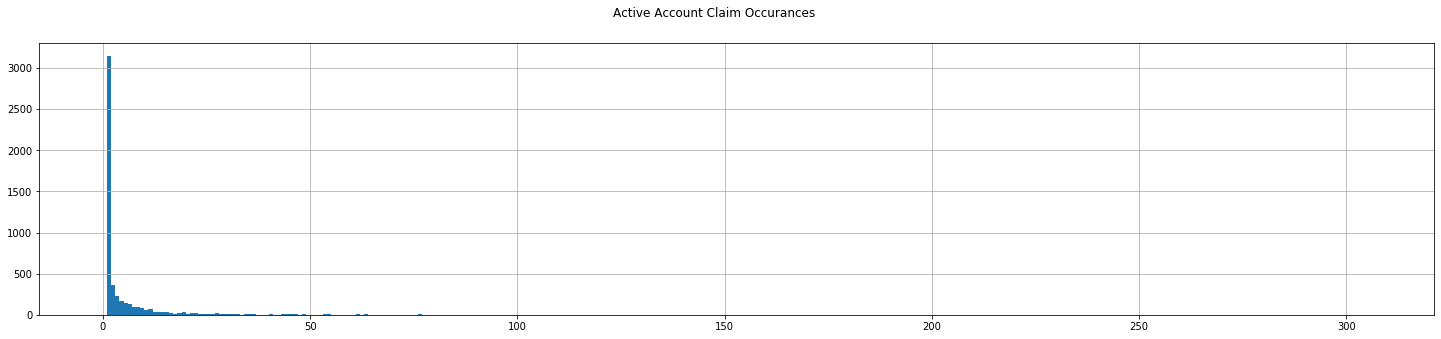

In [6]:
#Select Active Accounts
master_df.CancelDate = master_df.CancelDate.astype(str)
active = master_df.query('CancelDate == "nan"')

#Count occurences Pet_Id Claims
occurence = active['PetId'].value_counts(ascending=True)

#Occurence Histogram
occurence.hist(range=(0,occurence.max()),bins=occurence.max(),figsize=(25,5))
plt.suptitle('Active Account Claim Occurances')

occurence.describe()
#NOTE: Heavily Skewed less than 5 occurences

#create df for active accounts with less than 5 claims
occ_df= pd.DataFrame(occurence).reset_index()
occ_df.columns=['PetId','Count']




<h2>Split Data into sets with or without 5 or more historical data points</h2>

In [135]:
few_claims = occ_df.query('Count <=5')
many_claims = occ_df.query('Count >=6')

#Rejoin few claims with claim data
few_claims_df = few_claims.join(master_df, on='PetId', how='inner',rsuffix='_')
few_claims_df.sort_values(by='PetId')

many_claims_df = many_claims.join(master_df, on='PetId', how='inner',rsuffix='_')
many_claims_df.sort_values(by='PetId')

,PetId,Count,PetId_,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,ClaimId,ClaimDate,ClaimAmount
4690,2,14,2,2014-12-20,nan,Dog,French Bulldog,8 weeks to 12 months old,7633.0,2018-02-14,82.80
4690,2,14,2,2014-12-20,nan,Dog,French Bulldog,8 weeks to 12 months old,13987.0,2018-08-07,190.69
4690,2,14,2,2014-12-20,nan,Dog,French Bulldog,8 weeks to 12 months old,37156.0,2018-06-04,278.88
4690,2,14,2,2014-12-20,nan,Dog,French Bulldog,8 weeks to 12 months old,35617.0,2016-01-08,61.06
4690,2,14,2,2014-12-20,nan,Dog,French Bulldog,8 weeks to 12 months old,35616.0,2017-06-03,63.25
...,...,...,...,...,...,...,...,...,...,...,...
4354,9998,8,9998,2015-11-15,nan,Cat,Mixed Breed,8 weeks to 12 months old,11813.0,2016-12-14,547.56
4354,9998,8,9998,2015-11-15,nan,Cat,Mixed Breed,8 weeks to 12 months old,11814.0,2016-12-20,382.12
4354,9998,8,9998,2015-11-15,nan,Cat,Mixed Breed,8 weeks to 12 months old,12062.0,2016-12-26,5009.40
4354,9998,8,9998,2015-11-15,nan,Cat,Mixed Breed,8 weeks to 12 months old,26490.0,2018-11-17,661.25


<h2>Categorical-Claim correlation and relationships</h2>
<p>Rational: <br>There is not enough claim data to do forecasting for this subset of PetId's <br>
    Thus, some heuristics will need to be employed to guestimate based upon categorical data and relationships <br><br>
I am looking for meaningful correlation between pet categorical information and ClaimAmount <br>
If no strong relationship can be established, a decision-tree-like method will be used to downselect to the median of a given class of classes <br>
e.g. median(Dog & Mixed Breed & 3 years old)</p>
<p><br>NOTE: This only applies to the subset of PetId's with claim counts less than 3 <br>
All others will use forecasting methods</p>

In [8]:
#look again at correlations with ClaimAmount
corr_helper(few_claims_df)

Species Correlations 
 Cat   -0.005729
Dog    0.005729
dtype: float64 

Breed Correlations 
 Chihuahua           0.014550
French Bulldog      0.003084
Golden Retriever   -0.025802
Great Dane          0.004992
Mixed Breed        -0.002532
Ragdoll             0.053293
dtype: float64 

AgeAtEnroll Correlations 
 0-7 weeks old               0.002078
1 year old                  0.017216
10 years old                0.010805
11 years old                0.015500
12 years old               -0.007855
13 years old                0.005738
2 years old                 0.000208
3 years old                -0.012978
4 years old                -0.002002
5 years old                 0.013562
6 years old                 0.004668
7 years old                -0.020227
8 weeks to 12 months old   -0.014087
8 years old                 0.028213
9 years old                -0.024736
dtype: float64 



In [9]:
subset = few_claims_df.query('AgeAtEnroll == "9 years old"')
subset.ClaimAmount.describe()
#subset.ClaimAmount.median()



count     30.000000
mean     292.946333
std      240.013709
min        2.600000
25%       94.345000
50%      207.935000
75%      404.250000
max      912.170000
Name: ClaimAmount, dtype: float64

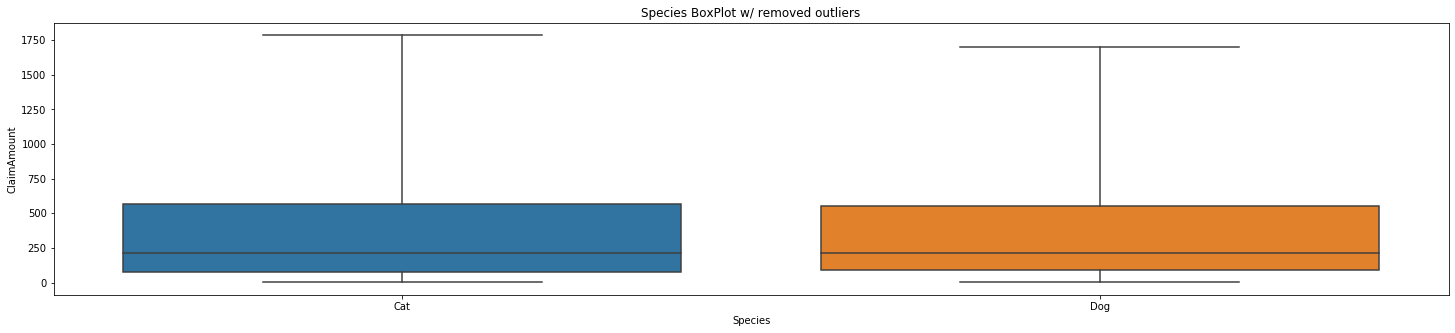

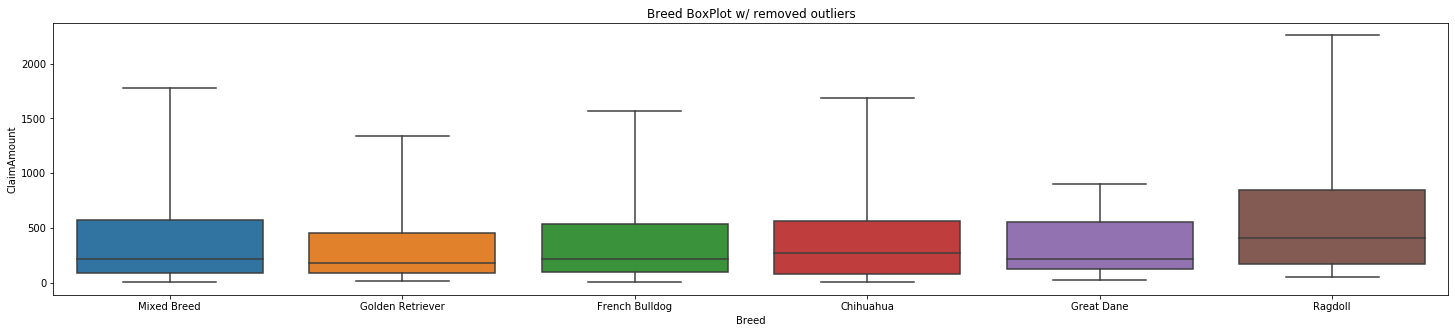

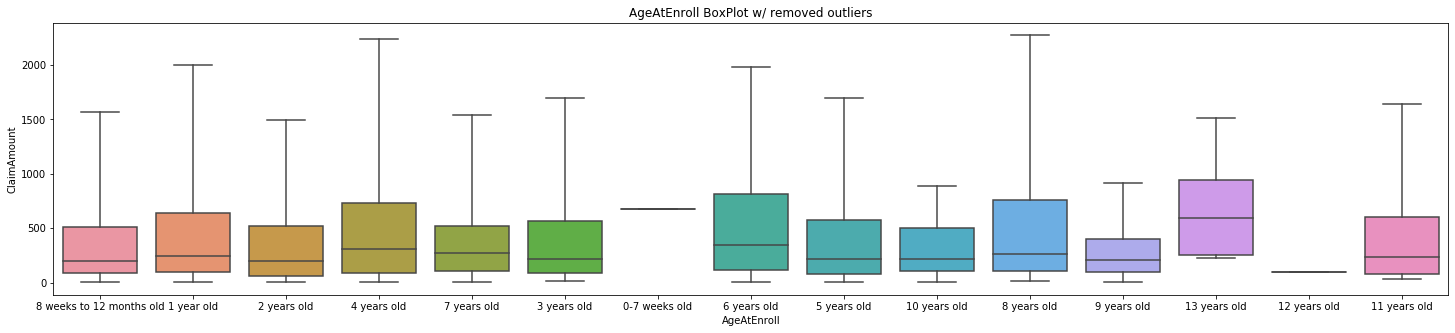

In [10]:
#NOTE
# Matplotlib uses 1.5*IQR as default to determine outliers to remove
# tested with 2.5
categories = ['Species','Breed','AgeAtEnroll']
for category in categories:
    plt.figure(figsize=(25,5))
    plt.title(category+' BoxPlot w/ removed outliers')
    sns.boxplot(x=few_claims_df[category],y=few_claims_df['ClaimAmount'],showfliers=False, whis=2.5)

<h2>few_claims predicted value lookup table</h2>
<p>Correlation does not exist in a meaningful manner</p>

<p><br> Build lookup table for union of categories and resultant median ClaimAmount value <br>
e.g. median(Dog & Mixed breed & 3 years old</p>

In [11]:


species_set = ['Dog','Cat']
age_set = master_df['AgeAtEnroll'].unique()
breed_set = master_df['Breed'].unique()


#Sloppy and Slow but it gets the job done for small datasets

nested_dict = lambda: defaultdict(nested_dict)
stats_lookup = nested_dict()

for species in species_set:
    for breed in breed_set:
        for age in age_set:
            
            #Query and frame it
            query_string = 'Species == "{}" & Breed == "{}" & AgeAtEnroll == "{}"'.format(species,breed,age)
            subset = master_df.query(query_string)
            subset = subset['ClaimAmount']
            
            #Nested dictionary for lookup
            stats_lookup[species][breed][age] = {'mean':subset.mean(),'median':subset.median(),
                                                 '1st_quantile':subset.quantile(.25),'2nd_quantile':subset.quantile(.75),
                                                'max':subset.max(),'min':subset.min()}
            

stats_lookup_df = pd.DataFrame.from_dict(stats_lookup)    



C:\Users\D4rkmatter\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


<h2>Sanity Check</h2>

In [12]:
#My lookup table

stats_lookup_df[0:10]
stats_lookup['Dog']['French Bulldog']['5 years old']

{'mean': 588.2666666666668,
 'median': 252.42,
 '1st_quantile': 206.70999999999998,
 '2nd_quantile': 801.9000000000001,
 'max': 1351.38,
 'min': 161.0}

In [13]:
#query from the dataframe

master_df.query('Species == "Dog" & Breed =="French Bulldog" & AgeAtEnroll == "5 years old"')

,PetId,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,ClaimId,ClaimDate,ClaimAmount
4725,4725,2013-02-19,2013-06-27,Dog,French Bulldog,5 years old,NaN,NaN,NaN
6204,6204,2018-10-05,nan,Dog,French Bulldog,5 years old,NaN,NaN,NaN
9992,9992,2015-04-28,nan,Dog,French Bulldog,5 years old,20954.0,2016-11-23,1351.38
9992,9992,2015-04-28,nan,Dog,French Bulldog,5 years old,30442.0,2016-11-22,161.00
9992,9992,2015-04-28,nan,Dog,French Bulldog,5 years old,34450.0,2017-12-09,252.42


#NOTE
Need to compare median of a given PetID's class to it's actual previous value(s)
Will show if we're being crazy to guess median of class as opposed to previous data

<h1>Enough data for forecasting (many_claims)</h1>

In [234]:
many_claims_df

,PetId,Count,PetId_,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,ClaimId,ClaimDate,ClaimAmount
4105,8860,6,8860,2012-09-26,nan,Dog,Great Dane,4 years old,31217.0,2019-06-30,752.00
4600,5654,12,5654,2011-05-27,nan,Dog,Golden Retriever,8 weeks to 12 months old,28490.0,2019-06-30,202.80
4600,5654,12,5654,2011-05-27,nan,Dog,Golden Retriever,8 weeks to 12 months old,28492.0,2019-06-30,1524.04
4977,3977,33,3977,2015-02-23,nan,Dog,Mixed Breed,9 years old,37550.0,2019-06-30,16.46
4989,6478,35,6478,2013-07-17,nan,Dog,Mixed Breed,5 years old,28468.0,2019-06-30,57.71


<h2>Data Encoding</h2>
<p>Species, Breed, AgeAtEnroll ==> One Hot</p>
<p>EnrollDate,ClaimDate ==> int( Current_month-first_entry_month )</p>
<p>int( ClaimAmount )</p>

In [193]:
def make_train_set(df):
    df = df.dropna()
    #create separate df for training
    clean_df = pd.DataFrame()
    clean_df['PetId'] = df['PetId'].astype(np.int64)
    
    #Encode ClaimDate
    df['ClaimDate'] = pd.to_datetime(df['ClaimDate'])    
    clean_df['ClaimDate_delta'] = (df['ClaimDate'] - df['ClaimDate'].min())  / np.timedelta64(1,'M')

    #Encode Enroll Date
    df['EnrollDate'] = pd.to_datetime(df['EnrollDate'])    
    clean_df['EnrollDate_delta'] = (df['EnrollDate'] - df['EnrollDate'].min())  / np.timedelta64(1,'M')

    #Clean up dtypes 
    clean_df['EnrollDate_delta'] = clean_df['EnrollDate_delta'].astype(np.int64)
    clean_df['ClaimDate_delta'] = clean_df['ClaimDate_delta'].astype(np.int64)
    clean_df['ClaimAmount'] = df['ClaimAmount'].astype(np.int64)

    #Encode categories
    clean_df = pd.concat([clean_df, pd.get_dummies(df['Species'])],axis=1)
    clean_df = pd.concat([clean_df, pd.get_dummies(df['Breed'])],axis=1)
    clean_df = pd.concat([clean_df, pd.get_dummies(df['AgeAtEnroll'])],axis=1)

    return(clean_df)


In [236]:
clean_df

,PetId,ClaimDate_delta,EnrollDate_delta,ClaimAmount,Cat,Dog,Chihuahua,French Bulldog,Golden Retriever,Great Dane,...,13 years old,2 years old,3 years old,4 years old,5 years old,6 years old,7 years old,8 weeks to 12 months old,8 years old,9 years old
8860,8860,105,34,360,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
8860,8860,105,34,294,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
8860,8860,105,34,338,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
8860,8860,105,34,294,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
8860,8860,113,34,752,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
8860,8860,92,34,2793,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [277]:
clean_df = make_train_set(master_df)
clean_df.to_csv('master_clean_data.csv')

many_clean_df = make_train_set(many_claims_df)

C:\Users\D4rkmatter\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\D4rkmatter\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [274]:
#check correlation
many_clean_df['EnrollDate_delta'].corr(many_clean_df['ClaimAmount'])

many_clean_df['ClaimDate_delta'].corr(many_clean_df['ClaimAmount'])

0.024745924189777422

In [240]:
from sklearn import linear_model

In [241]:
petids = many_clean_df['PetId'].unique()
pet_pred = {}
july = 106
for pet in petids:
    holder = many_clean_df.query('PetId == {}'.format(pet))
    holder.sort_values(by='ClaimDate_delta')
    y = holder.ClaimAmount.values
    X = holder.ClaimDate_delta.values.reshape(-1,1)
    
    reg = sk.linear_model.LinearRegression().fit(X,y)
    pet_pred[pet]=reg.predict(july)
    
    fig=plt.figure(figsize=(25,5))
    ax=fig.add_axes([0,0,1,1])
    ax.scatter(holder.ClaimDate_delta, test.ClaimAmount, color='r')

    plt.show()

    count+=1
    if count ==10:
        break
    

ValueError: Expected 2D array, got scalar array instead:
array=106.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [279]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from scipy import stats

#std_dev = 3
#many_clean_df = many_clean_df[(np.abs(stats.zscore(many_clean_df)) < float(std_dev)).all(axis=1)]

#simple linear regression
y = pd.DataFrame(many_clean_df['ClaimAmount'])
X = pd.DataFrame(many_clean_df['ClaimDate_delta'])

lm = linear_model.LinearRegression()
model = lm.fit(X,y)



In [280]:
lm.score(X,y)

0.0006123607640060591

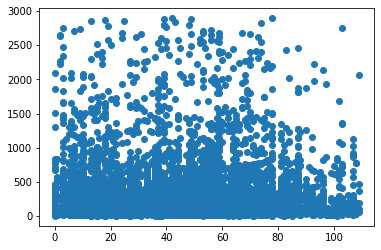

In [260]:
plt.scatter(many_clean_df['EnrollDate_delta'],many_clean_df['ClaimAmount'])

In [267]:
print(scores)

[-0.0015649683046372598, 0.0018289307634624663, 0.002362889822452363]


In [259]:
many_clean_df

,PetId,ClaimDate_delta,EnrollDate_delta,ClaimAmount,Cat,Dog,Chihuahua,French Bulldog,Golden Retriever,Great Dane,...,13 years old,2 years old,3 years old,4 years old,5 years old,6 years old,7 years old,8 weeks to 12 months old,8 years old,9 years old
4059,7605,96,2,39,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4059,7605,96,2,32,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4059,7605,95,2,2657,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4059,7605,95,2,2224,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4059,7605,72,2,2641,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5120,3957,77,38,67,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
5120,3957,71,38,34,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
5120,3957,100,38,124,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
5120,3957,79,38,63,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


<h2>Forecast Test</h2>

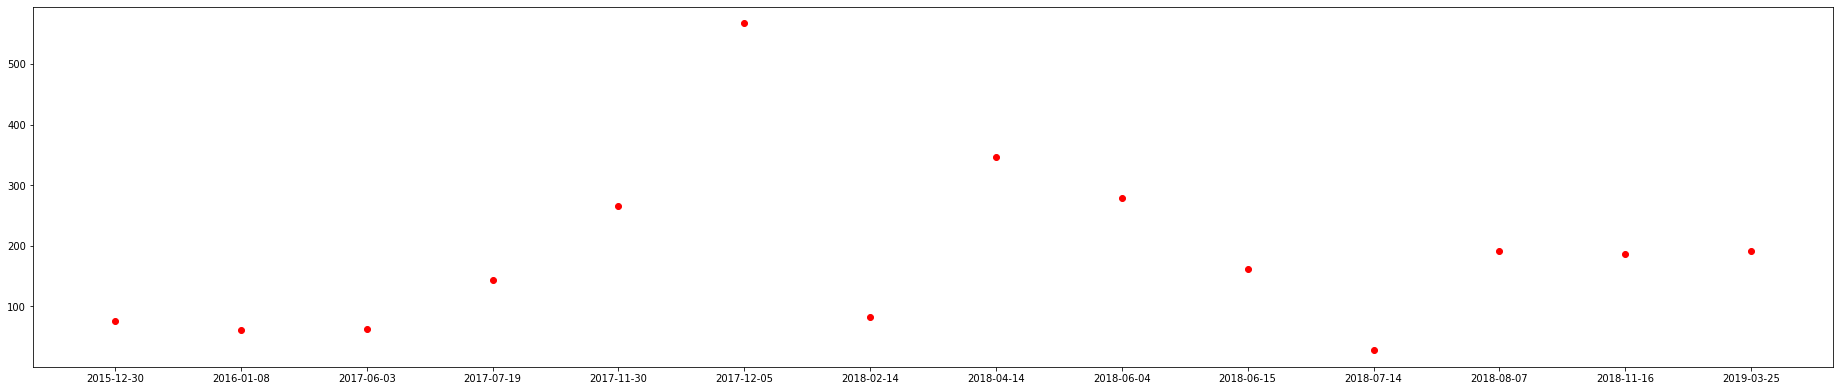

In [20]:
test = many_claims_df.query('PetId == 2')
test = test.sort_values(by='ClaimDate')

#ax = sns.scatterplot(x=test.ClaimDate, y=test.ClaimAmount)
fig=plt.figure(figsize=(25,5))
ax=fig.add_axes([0,0,1,1])
ax.scatter(test.ClaimDate, test.ClaimAmount, color='r')

plt.show()

#sns.regplot(test.ClaimDate, test.ClaimAmount)


<h2>Main Loop</h2>
<p>Per PetId, run forecast models <br>
predict for t(july) <br>
save results in dictionary per PetId</p>

In [424]:
pet_ids = many_claims_df['PetId'].unique()
len(pet_ids)

for pet_id in pet_ids:
    
    subset = many_claims_df.query('PetId == {}'.format(pet_id))
    subset.sort_values(by='ClaimDate')
    x = subset.ClaimDate
    y = ClaimAmount
    

1063

<h2>Forecasting Ensamble</h2>
<p>Autoregression <br> Moving Average <br> ARIMA <br>HW Exponential Smoothing</p>

In [50]:
input_df =claim_data.sort_values(by='PetId')
input_df.info()
for index,row in input_df.iterrows():
    print(row['PetId'], row[''])


<class 'pandas.core.frame.DataFrame'>
Int64Index: 37049 entries, 24463 to 11428
Data columns (total 4 columns):
ClaimId        37049 non-null int64
PetId          37049 non-null int64
ClaimDate      37049 non-null object
ClaimAmount    37049 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.4+ MB
